In [1]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import simulator
import generator

import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed


In [2]:

# The objective is to find how many steps are needed to reach steady state

NUMBER_OF_SIMULATIONS = 10
NUMBER_OF_BIG_STEPS = 500 # 1000 * 100 = 100000 steps
BIG_STEP_SIZE = 1000 # 100 steps
CHANNEL_RESERVED_FOR_HANDOVER = (0,1)

# results to collect are blocked, dropped, completed.

def run_simulations(seed, channel_reserved_for_handover):
    results = np.zeros((NUMBER_OF_BIG_STEPS, 3), dtype=int)

    gen = generator.Generator(seed=seed)
    # Create a simulator object
    sim = simulator.Simulator(gen, channel_reserved_for_handover)

    for i in range(NUMBER_OF_BIG_STEPS):
        sim.run(BIG_STEP_SIZE)
        # Collect results
        results[i, 0] = sim.dropped_calls
        results[i, 1] = sim.blocked_calls
        results[i, 2] = sim.completed_calls

    return results

    

In [3]:
results = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUMBER_OF_BIG_STEPS, 3), dtype=int)

for i, channel_reserved_for_handover in enumerate(CHANNEL_RESERVED_FOR_HANDOVER):
    desc = f"Simulations for reserved channel {channel_reserved_for_handover}"
    with ThreadPoolExecutor(10) as executor:
        futures = {
            executor.submit(run_simulations, j, channel_reserved_for_handover): j
            for j in range(NUMBER_OF_SIMULATIONS)
        }

        for future in tqdm.tqdm(as_completed(futures), total=NUMBER_OF_SIMULATIONS, desc=desc):
            j = futures[future]
            results[i, j] = future.result()

Simulations for reserved channel 1: 100%|██████████| 10/10 [02:04<00:00, 12.45s/it]


Estimated steps until steady state:

Reserved channels: 0
Dropped calls: Step 379.0 (Simulation time: 379000.0 steps)
Blocked calls: Step 275.0 (Simulation time: 275000.0 steps)

Reserved channels: 1
Dropped calls: Step 276.0 (Simulation time: 276000.0 steps)
Blocked calls: Step 474.0 (Simulation time: 474000.0 steps)


Text(0.5, 0.01, 'Dashed lines indicate estimated steady state points')

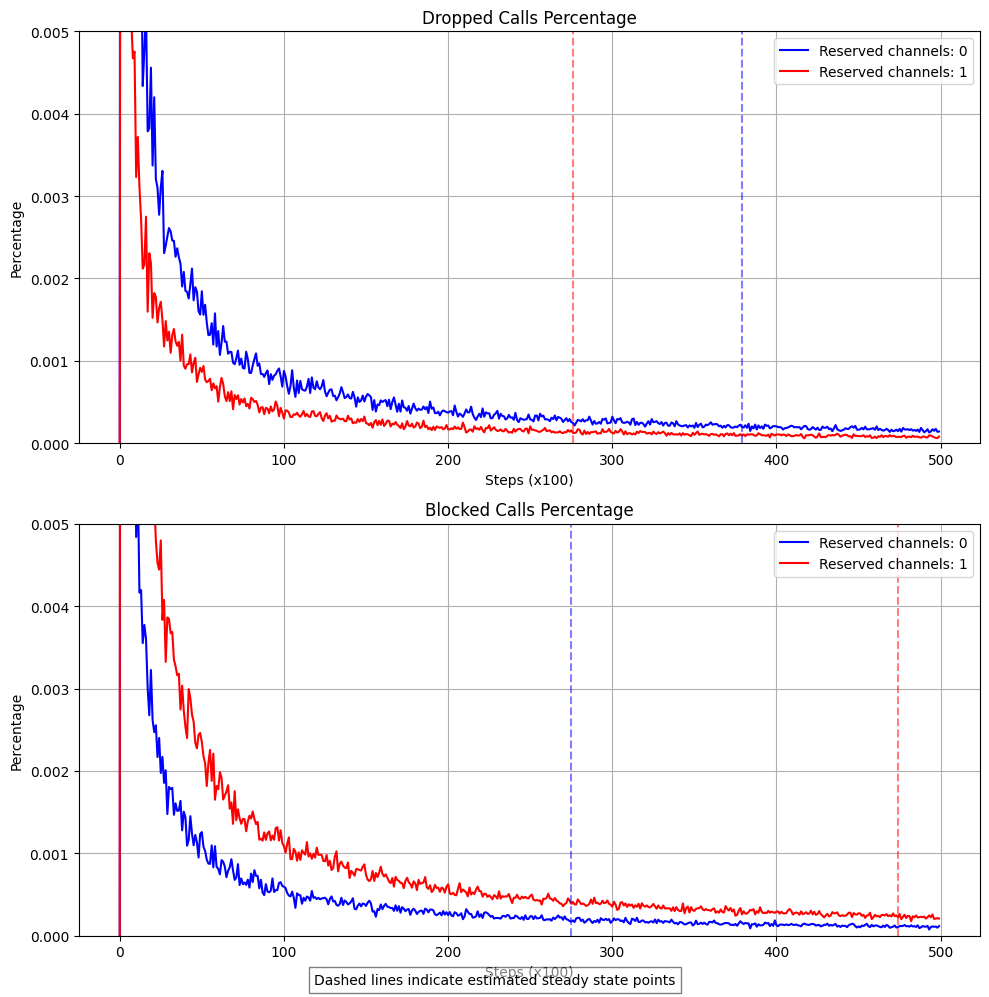

In [ ]:

# get the section cnt of each blocked, dropped, completed calls, ie no_blocked_n - no_blocked_n-1
results_diff = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUMBER_OF_BIG_STEPS, 3), dtype=int)
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    for j in range(NUMBER_OF_SIMULATIONS):
        for k in range(1, NUMBER_OF_BIG_STEPS):
            results_diff[i, j, k] = results[i, j, k] - results[i, j, k-1]

# make them into 2 percentages of the total number of calls
# ie blocked / (blocked + dropped + completed) and dropped / (blocked + dropped + completed)
results_diff_percentage = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUMBER_OF_BIG_STEPS, 2), dtype=float)
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    for j in range(NUMBER_OF_SIMULATIONS):
        for k in range(NUMBER_OF_BIG_STEPS):
            total = results[i, j, k, 0] + results[i, j, k, 1] + results[i, j, k, 2]
            if total > 0:
                results_diff_percentage[i, j, k, 0] = results_diff[i, j, k, 0] / total
                results_diff_percentage[i, j, k, 1] = results_diff[i, j, k, 1] / total

# plot the results for blocked and dropped calls (removing completed calls)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# Set steps for x-axis
steps = np.arange(NUMBER_OF_BIG_STEPS)

# Plot dropped calls percentage for all simulations
colors = ['blue', 'red']
labels = ['Reserved channels: 0', 'Reserved channels: 1']

for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    # Average across all simulations
    dropped_pct = np.mean(results_diff_percentage[i, :, :, 0], axis=0)
    blocked_pct = np.mean(results_diff_percentage[i, :, :, 1], axis=0)
    
    # Plot dropped calls
    axs[0].plot(steps, dropped_pct, color=colors[i], label=labels[i])
    axs[0].set_title('Dropped Calls Percentage')
    axs[0].set_xlabel('Steps (x100)')
    axs[0].set_ylabel('Percentage')
    axs[0].set_ylim(0, 0.005)  # Set y-axis max to 0.001
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot blocked calls
    axs[1].plot(steps, blocked_pct, color=colors[i], label=labels[i])
    axs[1].set_title('Blocked Calls Percentage')
    axs[1].set_xlabel('Steps (x100)')
    axs[1].set_ylabel('Percentage')
    axs[1].set_ylim(0, 0.005)  # Set y-axis max to 0.001
    axs[1].legend()
    axs[1].grid(True)

fig.tight_layout()

# Define a function to find the point of steady state
def find_steady_state(data, window_size=50, threshold=0.00002):
    """
    Find the step where the system reaches steady state.
    
    Parameters:
    - data: array of percentages over time
    - window_size: size of the rolling window to check for stability
    - threshold: maximum standard deviation allowed in the window to consider it stable
    
    Returns:
    - step where steady state begins
    """
    for i in range(window_size, len(data)):
        window = data[i-window_size:i]
        if np.std(window) < threshold:
            return i
    return len(data)  # If no steady state found, return the last step

# Find steady state for each case
steady_states = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), 2))  # [dropped, blocked] for each reservation setting

STEADY_STATE_THRESHOLD = 0.00002  # Define a threshold for steady state

for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    # Average across all simulations
    dropped_pct = np.mean(results_diff_percentage[i, :, :, 0], axis=0)
    blocked_pct = np.mean(results_diff_percentage[i, :, :, 1], axis=0)
    
    # Find steady state points
    steady_dropped = find_steady_state(dropped_pct, STEADY_STATE_THRESHOLD)
    steady_blocked = find_steady_state(blocked_pct, STEADY_STATE_THRESHOLD)
    
    steady_states[i, 0] = steady_dropped
    steady_states[i, 1] = steady_blocked

# Print the steps where steady state begins (in terms of steps and actual simulation time)
print("Estimated steps until steady state:")
for i, channels in enumerate(CHANNEL_RESERVED_FOR_HANDOVER):
    print(f"\nReserved channels: {channels}")
    print(f"Dropped calls: Step {steady_states[i, 0]} (Simulation time: {steady_states[i, 0] * BIG_STEP_SIZE} steps)")
    print(f"Blocked calls: Step {steady_states[i, 1]} (Simulation time: {steady_states[i, 1] * BIG_STEP_SIZE} steps)")

# Add vertical lines to the plots indicating steady state points
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    axs[0].axvline(x=steady_states[i, 0], color=colors[i], linestyle='--', alpha=0.5)
    axs[1].axvline(x=steady_states[i, 1], color=colors[i], linestyle='--', alpha=0.5)

# Add a textbox explaining the dashed lines
fig.text(0.5, 0.01, 'Dashed lines indicate estimated steady state points', 
         ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
